## Investing Model
This model consists of several models in order to better invest in the S&P500

In [251]:
import pandas as pd
import numpy as np
from google.colab import drive
from sklearn.metrics import accuracy_score

drive.mount('/content/drive')

stock = pd.read_csv("/content/drive/My Drive/New Data/^GSPC.csv")
DJI = pd.read_csv("/content/drive/My Drive/New Data/^DJI.csv")
AAPL = pd.read_csv("/content/drive/My Drive/New Data/AAPL.csv")
GOOG = pd.read_csv("/content/drive/My Drive/New Data/GOOG.csv")
GS = pd.read_csv("/content/drive/My Drive/New Data/GS.csv")
PMI = pd.read_csv("/content/drive/My Drive/New Data/ISM-MAN_PMI.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
headlines = pd.read_csv("/content/drive/My Drive/New Data/abcnews-date-text.csv")
finance_headlines = pd.read_csv("/content/drive/My Drive/New Data/news.csv")

## PMI Index

In [0]:
PMI.Date = pd.to_datetime(PMI.Date, format='%Y-%m-%d', errors='ignore')
PMI = PMI.iloc[::-1]
PMI['PMI_Change'] = PMI['PMI'].diff()

PMI.set_index('Date', inplace=True)
offset = pd.offsets.DateOffset(0)

PMI.resample('D', loffset=offset).ffill()
PMI = PMI.resample('D', loffset=offset).ffill()



##News Headlines (Finance)

In [253]:
finance_headlines.columns = ['Website', 'Date', 'headline_text', 'Source']
finance_headlines.Date = pd.to_datetime(finance_headlines.Date)
finance_headlines.Date = finance_headlines['Date'].dt.strftime('%Y-%m-%d')
finance_headlines.Date = pd.to_datetime(finance_headlines.Date)
finance_headlines[(finance_headlines['headline_text'].str.contains("Twitter"))]

,Website,Date,headline_text,Source
29709,us-twitter-facebook,2008-11-25,Facebook targeted Twitter: report,Reuters Social networking company Facebook r...
35649,us-twitter-google,2009-04-03,Blogs clash over whether Google could buy Twitter,NEW YORK Reuters Two prominent technology n...
37443,us-summit-twitter,2009-05-18,Twitter sees tools not ads for revenue,NEW YORK Reuters Twitter is working on vari...
39448,us-sunvalley-socialnetworks-analysis-sb,2009-07-10,Do social networks like Twitter belong in media?,SUN VALLEY Idaho Reuters If theres one grou...
41935,us-twitter-funding,2009-09-16,Twitter funding would value it at $1 billion: ...,SAN FRANCISCO Reuters Twitter is closing a ...
...,...,...,...,...
104919,us-exchanges-listings-twitter-analysis,2013-11-09,Analysis: Twitter gives NYSE momentum in IPO b...,NEW YORK Reuters Twitter Incs successful de...
104924,us-usa-tech-ipos,2013-11-09,Twitter IPO sparks speculation on who could fo...,SAN FRANCISCO Reuters For technology execut...
104968,us-twitter-ipo-islamic,2013-11-11,Twitter shares found suitable for Islamic inve...,DUBAI Reuters Shares in Twitter Inc have be...
105095,us-twitter-ipo-shorts,2013-11-13,Short sellers test the waters on Twitter,NEW YORK Reuters Short sellers are starting...


##News Headlines (Normal)

In [0]:
headlines.publish_date = pd.to_datetime(headlines.publish_date, format='%Y%m%d', errors='ignore')
headlines.columns = ['Date', 'headline_text']


In [255]:
headlines[(headlines['headline_text'].str.contains(" f"))]

,Date,headline_text
1,2003-02-19,act fire witnesses must be aware of defamation
2,2003-02-19,a g calls for infrastructure protection summit
3,2003-02-19,air nz staff in aust strike for pay rise
7,2003-02-19,aussie qualifier stosur wastes four memphis match
13,2003-02-19,big hopes for launceston cycling championship
...,...,...
1103655,2017-12-31,south australia prepares for party to welcome ...
1103657,2017-12-31,stunning images from the sydney to hobart yacht
1103659,2017-12-31,timelapse: brisbanes new year fireworks
1103661,2017-12-31,what the papodopoulos meeting may mean for ausus


##AAPL Stock

In [0]:
AAPL.Date = pd.to_datetime(AAPL.Date, format='%Y-%m-%d')
AAPL['Average'] = (AAPL.High+AAPL.Low)/2
# AAPL['Average'] = AAPL.Close - AAPL.Low
# AAPL['Average'] = (AAPL.Close-AAPL.Open)

##GOOG Stock

In [0]:
GOOG.Date = pd.to_datetime(GOOG.Date, format='%Y-%m-%d')
GOOG['Average'] = (GOOG.High+GOOG.Low)/2

##Goldman Sachs

In [0]:
GS.Date = pd.to_datetime(GS.Date, format='%Y-%m-%d')
GS['Average'] = (GS.High+GS.Low)/2

##DJI Index

In [0]:
DJI.Date = pd.to_datetime(DJI.Date, format='%Y-%m-%d')
DJI['Average'] = (DJI.High+DJI.Low)/2
# DJI['Average'] = (DJI.Close-DJI.Open)


##S&P500

In [0]:
headlines.publish_date = pd.to_datetime(headlines.publish_date, format='%Y%m%d', errors='ignore')
headlines.columns = ['Date', 'headline_text']
stock.Date = pd.to_datetime(stock.Date, format='%Y-%m-%d')
stock['Average'] = (stock.High+stock.Low)/2
# stock['Average'] = (stock.Close-stock.Open)
data = pd.merge(stock, finance_headlines, how='inner', on='Date')

# .merge(PMI, how='inner', on='Date')

AttributeError: ignored

##Merging of News Headlines & stock

In [0]:
data = pd.merge(AAPL, finance_headlines, how='inner', on='Date')

In [260]:
data = data.drop(columns=['Source', 'Website'])
data

,Date,Open,High,Low,Close,Adj Close,Volume,Average,headline_text
0,2006-10-20,11.281428,11.427143,11.238571,11.421429,9.967632,159853400.0,11.332857,Hey buddy can you spare $600 for a Google share?
1,2006-10-23,11.427143,11.700000,11.392858,11.637143,10.155888,208126800.0,11.546429,DaimlerChrysler talks to 2 firms on small car:...
2,2006-10-23,11.427143,11.700000,11.392858,11.637143,10.155888,208126800.0,11.546429,Australia's Foster's says confident on targets
3,2006-10-23,11.427143,11.700000,11.392858,11.637143,10.155888,208126800.0,11.546429,UPDATE 4-Wal-Mart to slow U.S. expansion spend...
4,2006-10-23,11.427143,11.700000,11.392858,11.637143,10.155888,208126800.0,11.546429,Ford posts biggest loss in 14 years
...,...,...,...,...,...,...,...,...,...
92830,2013-11-19,74.147141,74.768570,73.995712,74.221428,66.990891,52234700.0,74.382141,JPMorgan agrees $13 billion settlement with U....
92831,2013-11-19,74.147141,74.768570,73.995712,74.221428,66.990891,52234700.0,74.382141,Dow S&P retreat for second day; Best Buy weighs
92832,2013-11-19,74.147141,74.768570,73.995712,74.221428,66.990891,52234700.0,74.382141,Bernanke: looking forward to writing speaking ...
92833,2013-11-19,74.147141,74.768570,73.995712,74.221428,66.990891,52234700.0,74.382141,Bernanke: Fed committed to easy policy for as ...


In [261]:
dummy = data.groupby("Date").mean().diff()['Close']
dummy[dummy > 0] = 1
dummy[dummy < 0] = 0
dummy = dummy.rename("Change")
dummy

Date
2006-10-20    NaN
2006-10-23    1.0
2006-10-24    0.0
2006-10-25    1.0
2006-10-26    1.0
             ... 
2013-11-13    1.0
2013-11-14    1.0
2013-11-15    0.0
2013-11-18    0.0
2013-11-19    1.0
Name: Change, Length: 1781, dtype: float64

In [279]:
def compileData(symbole):
  stock = symbole
  stock.Date = pd.to_datetime(stock.Date, format='%Y-%m-%d')
  stock['Average'] = (stock.High+stock.Low)/2
  mergedData = pd.merge(stock, finance_headlines, how='inner', on='Date')
  mergedData = mergedData.drop(columns=['Source', 'Website'])

  dummy1 = mergedData.groupby("Date").mean().diff()['Close']
  dummy1[dummy1 > 0] = 1
  dummy1[dummy1 < 0] = 0
  dummy1 = dummy1.rename("Change")

  mergedData = mergedData.merge(dummy1, how='inner', on='Date').dropna()
  return(mergedData)
  
def filter(data1, filterArray):
  return(data1[(data1['headline_text'].str.contains(filterArray))])

data = filter(compileData(GS), "Goldman")
data

,Date,Open,High,Low,Close,Adj Close,Volume,Average,headline_text,Change
371,2006-11-06,187.679993,191.699997,187.679993,190.000000,161.807510,4639000,189.689995,Linde sells forklift unit Kion to Goldman KKR,1.0
1049,2006-11-30,195.979996,196.449997,193.179993,194.800003,165.895294,4082500,194.814995,Claire's seeking buyer hires Goldman Sachs: re...,0.0
1295,2006-12-08,200.240005,205.259995,200.000000,205.100006,174.666931,4968600,202.629998,Onex and Goldman in talks for Raytheon unit: s...,1.0
1374,2006-12-12,200.210007,203.850006,198.440002,200.000000,170.323639,8926200,201.145004,Goldman CFO says hedge fund woes could hit 1st...,0.0
1375,2006-12-12,200.210007,203.850006,198.440002,200.000000,170.323639,8926200,201.145004,Goldman profit almost doubles but investors wary,0.0
...,...,...,...,...,...,...,...,...,...,...
91874,2013-10-29,162.070007,163.110001,161.009995,162.110001,148.773041,3702100,162.059998,Goldman loses co-head of commodity trade Sheno...,1.0
91875,2013-10-29,162.070007,163.110001,161.009995,162.110001,148.773041,3702100,162.059998,Goldman loses co-head of commodity trade Sheno...,1.0
92264,2013-11-06,162.529999,164.300003,162.330002,163.520004,150.067078,3593700,163.315002,Goldman Sachs legal-loss reserves may be $4 bi...,1.0
92569,2013-11-13,161.779999,163.710007,161.199997,162.940002,149.534760,3398300,162.455002,Goldman Sachs names 280 managing directors as ...,1.0


## Merging of data

In [0]:
data = data.merge(dummy, how='inner', on='Date').dropna()


In [263]:
filter = data[(data['headline_text'].str.contains("Apple")) | (data['headline_text'].str.contains("Foxconn") | (data['headline_text'].str.contains("iPhone")) | (data['headline_text'].str.contains("iPad")))]
data = filter
data

,Date,Open,High,Low,Close,Adj Close,Volume,Average,headline_text,Change
258,2006-11-01,11.585714,11.625714,11.194285,11.308572,9.869141,152798100.0,11.410000,Apple pushes Oricon to quit PC music downloads,0.0
759,2006-11-20,12.200000,12.428572,12.171429,12.352858,10.780502,142698500.0,12.300000,"Mac fans buzzing about expected Apple ""iPhone""",1.0
1420,2006-12-13,12.564285,12.724286,12.450000,12.721429,11.102160,214263000.0,12.587143,Apple's iTunes music sales collapses in H1: su...,1.0
1502,2006-12-15,12.717143,12.745714,12.475715,12.531428,10.936343,184984800.0,12.610715,Apple files to delay annual report for option ...,0.0
1781,2006-12-27,11.164286,11.714286,10.967143,11.645715,10.163370,483938700.0,11.340715,Apple shares recover,1.0
...,...,...,...,...,...,...,...,...,...,...
92661,2013-11-14,74.687141,75.611427,74.552856,75.451431,68.101059,70604800.0,75.082142,Icahn owned 3.9 million shares of Apple as of ...,1.0
92662,2013-11-14,74.687141,75.611427,74.552856,75.451431,68.101059,70604800.0,75.082142,Hedge funds tune into Pandora discard Apple in...,1.0
92701,2013-11-18,74.998573,75.312859,74.028572,74.089996,66.872269,61236000.0,74.670716,U.S. appeals court revives Apple bid for Samsu...,0.0
92760,2013-11-19,74.147141,74.768570,73.995712,74.221428,66.990891,52234700.0,74.382141,In retrial Apple and Samsung make final pitche...,1.0


In [0]:

data = data.drop_duplicates(subset='Date', keep='last')
data

,Date,Open,High,Low,Close,Adj Close,Volume,Average,headline_text,Change
371,2006-11-06,187.679993,191.699997,187.679993,190.000000,161.807510,4639000,189.689995,Linde sells forklift unit Kion to Goldman KKR,1.0
1049,2006-11-30,195.979996,196.449997,193.179993,194.800003,165.895294,4082500,194.814995,Claire's seeking buyer hires Goldman Sachs: re...,0.0
1295,2006-12-08,200.240005,205.259995,200.000000,205.100006,174.666931,4968600,202.629998,Onex and Goldman in talks for Raytheon unit: s...,1.0
1375,2006-12-12,200.210007,203.850006,198.440002,200.000000,170.323639,8926200,201.145004,Goldman profit almost doubles but investors wary,0.0
1813,2006-12-28,202.330002,202.479996,199.759995,200.800003,171.004959,2395600,201.119996,Goldman raises $6.5 bln for infrastructure fund,0.0
...,...,...,...,...,...,...,...,...,...,...
91645,2013-10-23,158.020004,158.080002,156.559998,157.740005,144.762573,2735800,157.320000,Goldman Sachs hires new Asia Pacific e-trading...,0.0
91875,2013-10-29,162.070007,163.110001,161.009995,162.110001,148.773041,3702100,162.059998,Goldman loses co-head of commodity trade Sheno...,1.0
92264,2013-11-06,162.529999,164.300003,162.330002,163.520004,150.067078,3593700,163.315002,Goldman Sachs legal-loss reserves may be $4 bi...,1.0
92569,2013-11-13,161.779999,163.710007,161.199997,162.940002,149.534760,3398300,162.455002,Goldman Sachs names 280 managing directors as ...,1.0


## PMI MODEL
Take the first 5 days after the release of the PMI index.
If positive, invest for FIRST 5 days.
If negative, short for FIRST 5 days.

In [0]:
def pmi_model(start_date):
  start_date = pd.Timestamp(start_date)
  end_date = start_date + pd.Timedelta(days=5)
  mask = (data['Date'] > start_date) & (data['Date'] <= end_date)
  table = (data.loc[mask].groupby('Date').mean())
  
  if(table.PMI_Change[0] > 0.3):
    position="LONG"
    table['Position'] = position
    table['Profit'] = table['Average'].diff() 
    profit = table['Profit'].sum()
  elif(table.PMI_Change[0] < -0.3):
    position="SHORT"
    table['Position'] = position
    table['Profit'] = table['Average'].diff()*-1
    profit = abs(table['Profit'].sum())
  else:
    position = "NO POSITION"
    table['Position'] = position
    table['Profit'] = 0
    profit=0
  
  
  return(table)

In [0]:
filter = data[(data['headline_text'].str.contains("Apple") | data['headline_text'].str.contains("Google"))]
filter
headlines[headlines.headline_text.str.contains("iphone")]['publish_date']

89118      20040506
314124     20070630
314232     20070630
381806     20080506
388010     20080604
             ...   
1097362    20171103
1097365    20171103
1098107    20171109
1103317    20171227
1103462    20171229
Name: publish_date, Length: 103, dtype: int64

In [0]:
data = filter

##Sentimental Analysis of news Headlines


In [0]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
x = sid.polarity_scores("I am not angry")
headline_pos = []
headline_neg = []
headline_neu = []
for i in data.headline_text:
  sentiment = sid.polarity_scores(i)
  headline_pos.append(sentiment['pos'])
  headline_neg.append(sentiment['neg'])
  headline_neu.append(sentiment['neu'])



[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [0]:
# data['headline_pos'] = headline_pos
# data['headline_neg'] = headline_neg
# data['headline_neu'] = headline_neu
# data
data = data.drop_duplicates(subset='Date', keep='last')
data

# data['Headline Sentiments'].mean()

,Date,Open,High,Low,Close,Adj Close,Volume,Average,headline_text,Change,headline_pos,headline_neg,headline_neu
258,2006-11-01,11.585714,11.625714,11.194285,11.308572,9.869141,152798100.0,11.410000,Apple pushes Oricon to quit PC music downloads,0.0,0.000,0.000,1.000
759,2006-11-20,12.200000,12.428572,12.171429,12.352858,10.780502,142698500.0,12.300000,"Mac fans buzzing about expected Apple ""iPhone""",1.0,0.000,0.000,1.000
1420,2006-12-13,12.564285,12.724286,12.450000,12.721429,11.102160,214263000.0,12.587143,Apple's iTunes music sales collapses in H1: su...,1.0,0.000,0.239,0.761
1502,2006-12-15,12.717143,12.745714,12.475715,12.531428,10.936343,184984800.0,12.610715,Apple files to delay annual report for option ...,0.0,0.000,0.223,0.777
1781,2006-12-27,11.164286,11.714286,10.967143,11.645715,10.163370,483938700.0,11.340715,Apple shares recover,0.0,0.524,0.000,0.476
...,...,...,...,...,...,...,...,...,...,...,...,...,...
92479,2013-11-12,73.952858,74.845711,73.857140,74.287140,67.050186,51069200.0,74.351426,Apple's iPad Mini with retina display to go on...,1.0,0.000,0.000,1.000
92546,2013-11-13,74.000000,74.607140,73.851425,74.375717,67.130127,49305200.0,74.229283,Apple Samsung retrial kicks off over patent da...,0.0,0.000,0.293,0.707
92662,2013-11-14,74.687141,75.611427,74.552856,75.451431,68.101059,70604800.0,75.082142,Hedge funds tune into Pandora discard Apple in...,1.0,0.000,0.200,0.800
92701,2013-11-18,74.998573,75.312859,74.028572,74.089996,66.872269,61236000.0,74.670716,U.S. appeals court revives Apple bid for Samsu...,0.0,0.245,0.000,0.755


## Data splitting by date
Training data consists of a year's worth of price changes and headlines.
Testing consists of the first month after testing.

Goal is to achieve higher than 50% predictions for the testing dataset.

In [280]:
from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(data.headline_text, data.Change,shuffle=False, test_size=0.05)
testing_date = data[data.Date > '2013-08-10']
training_date = data[data.Date <= '2013-08-10']

X_train = training_date.headline_text
# X_train2 = training_date.PMI_Change

y_train = training_date.Change

X_test = testing_date.headline_text
# X_test2 = testing_date.PMI_Change

y_test = testing_date.Change
testing_date.shape


(36, 10)

In [281]:
X_train.shape

(1032,)

## Tokenization and Vectorization using CountVectorizer


In [0]:
#Tokenize/Vectorize the data into a vector of size 30,000
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(binary=False, stop_words='english')
train_data = vectorizer.fit_transform(X_train)

test_data = vectorizer.transform(X_test)
train_labels = y_train
test_labels = y_test

## Naive Bayes Model
Naive Bayes model for the prediction of stock movements with news headlines.


In [283]:

from sklearn.naive_bayes import BernoulliNB
import matplotlib as plt

bnb = BernoulliNB()
y_pred_train_nb = bnb.fit(train_data, train_labels).predict(train_data)
y_pred_test_nb = bnb.predict(test_data)

print("Bernoulli Naive Bayes Training Accuracy {0}".format(accuracy_score(train_labels, y_pred_train_nb)))
print("Bernoulli Naive Bayes Testing Accuracy {0}".format(accuracy_score(test_labels, y_pred_test_nb)))

Bernoulli Naive Bayes Training Accuracy 0.9147286821705426
Bernoulli Naive Bayes Testing Accuracy 0.5277777777777778


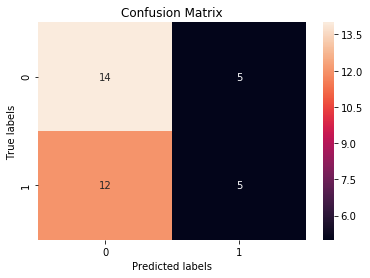

In [284]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn
cm= confusion_matrix(test_labels, y_pred_test_nb)
ax= plt.subplot()
sn.heatmap(cm, annot=True, ax=ax)
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 



## Logistics Regression

In [285]:
from sklearn import datasets
from sklearn.linear_model import LogisticRegression

#Logistics Training
clf = LogisticRegression().fit(train_data, train_labels)
y_pred_logistic_train = clf.predict(train_data)
y_pred_logistic_test = clf.predict(test_data)

print("Logistics Training Accuracy {0}".format(accuracy_score(train_labels, y_pred_logistic_train)))
print("Logistics Testing Accuracy {0}".format(accuracy_score(test_labels, y_pred_logistic_test)))


Logistics Training Accuracy 0.9544573643410853
Logistics Testing Accuracy 0.4444444444444444


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## Random Forest

In [286]:
from sklearn.ensemble import RandomForestClassifier
randomForest = RandomForestClassifier(max_features='auto', n_estimators=300, max_depth=1000)
randomForest.fit(train_data, train_labels)
y_pred_train_rf = randomForest.predict(train_data)
y_pred_test_rf = randomForest.predict(test_data)

print("Random Forest Training Accuracy {0}".format(accuracy_score(train_labels, y_pred_train_rf)))
print("Random Forest Testing Accuracy {0}".format(accuracy_score(test_labels, y_pred_test_rf)))


Random Forest Training Accuracy 0.9864341085271318
Random Forest Testing Accuracy 0.5


## Support Vector Classifcation


In [289]:
from sklearn import svm
clf = svm.SVC(gamma='scale', kernel='poly', degree=3)
clf.fit(train_data, train_labels)
y_pred_train_cvm = clf.predict(train_data)
y_pred_test_cvm = clf.predict(test_data)

print("SVC Training Accuracy {0}".format(accuracy_score(train_labels, y_pred_train_cvm)))
print("SVCt Testing Accuracy {0}".format(accuracy_score(test_labels, y_pred_test_cvm)))

SVC Training Accuracy 0.9786821705426356
SVCt Testing Accuracy 0.5833333333333334


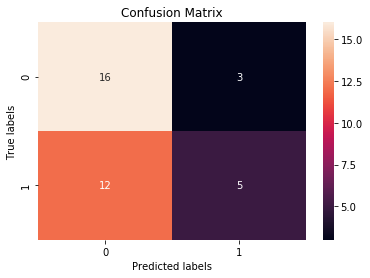

In [290]:
cm= confusion_matrix(test_labels, y_pred_test_cvm)
ax= plt.subplot()
sn.heatmap(cm, annot=True, ax=ax)
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 


##Predictions

## Deep Learning

In [0]:
from keras.models import Sequential
from keras import layers

model = Sequential()
model.add(layers.Dense(1000, input_shape=(13916,), activation='relu'))
model.add(layers.Dense(1000, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 1000)              13917000  
_________________________________________________________________
dense_34 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 1001      
Total params: 14,919,001
Trainable params: 14,919,001
Non-trainable params: 0
_________________________________________________________________


In [0]:
history = model.fit(train_data, train_labels,
                    validation_data=(test_data, test_labels),
                    epochs=1)


Train on 40409 samples, validate on 801 samples
Epoch 1/1
 8256/40409 [=====>........................] - ETA: 29s - loss: 0.6909 - acc: 0.5237

KeyboardInterrupt: ignored

## LSTM Model

In [0]:
from keras.models import Sequential
from keras import layers
from keras.layers import LSTM
from keras.layers.embeddings import Embedding


model = Sequential()
model.add(Embedding(100, 32, input_length=20638))
model.add(LSTM(100))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(train_data, y_train, epochs=3, batch_size=64)

(4751,)

##Daily Predictions

In [294]:
test = testing_date
test['Prediction'] = y_pred_test_cvm

training = training_date
training['Prediction'] = y_pred_train_cvm

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [295]:
daily_train = training.groupby('Date').mean()

daily_train['Prediction'][daily_train['Prediction'] < daily_train.Prediction.mean()] = 0
daily_train['Prediction'][daily_train['Prediction'] >= daily_train.Prediction.mean()] = 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [299]:
daily_test = test.groupby('Date').mean()

daily_test['Prediction'][daily_test['Prediction'] < 0.5] = 0
daily_test['Prediction'][daily_test['Prediction'] >= 0.5] = 1

daily_test


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Open,High,Low,Close,Adj Close,Volume,Average,Change,Prediction
Date,,,,,,,,,
2013-08-16,160.279999,162.289993,160.029999,160.660004,146.961197,2024300,161.159996,0.0,0.0
2013-08-20,158.720001,160.029999,157.779999,159.559998,145.955017,2288700,158.904999,1.0,0.0
2013-08-21,158.779999,159.229996,156.509995,157.110001,143.713898,3053800,157.869996,0.0,0.0
2013-08-23,159.589996,159.789993,158.000000,158.649994,145.122589,1495800,158.894996,1.0,0.0
2013-08-26,158.410004,160.699997,157.750000,157.899994,144.436569,1885200,159.224998,0.0,0.0
2013-08-28,153.000000,154.149994,151.449997,152.970001,140.385040,2343200,152.799995,0.0,0.0
2013-08-30,153.770004,153.979996,151.330002,152.130005,139.614090,2234000,152.654999,0.0,0.0
2013-09-09,157.410004,159.699997,157.160004,159.490005,146.368607,2150400,158.430001,1.0,0.0
2013-09-16,166.309998,168.570007,165.190002,167.029999,153.288269,3553100,166.880004,1.0,0.0


In [300]:
accuracy_score(daily_test.Change, daily_test.Prediction)

0.6521739130434783

In [301]:
arr=[]
for index, row in daily_test.iterrows():
  if(row.Prediction == 0):
    arr.append((row.Open-row.Close))
  if(row.Prediction == 1):
    arr.append((row.Close-row.Open))
sum(arr)

4.259992999999952

##Embedding and Deep Learning Attempt

In [0]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
corpus = X_train
all_words = []
for sent in corpus:
    tokenize_word = word_tokenize(sent)
    for word in tokenize_word:
        all_words.append(word)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [0]:
from keras.preprocessing.text import one_hot

unique_words = set(all_words)
vocab_length=10000
embedded_sentences = [one_hot(sent, vocab_length) for sent in corpus]


In [0]:
from keras.preprocessing.sequence import pad_sequences
word_count = lambda sentence: len(word_tokenize(sentence))
longest_sentence = max(corpus, key=word_count)
length_long_sentence1 = len(word_tokenize(longest_sentence))
padded_sentences = pad_sequences(embedded_sentences, length_long_sentence1, padding='post')


In [0]:
def pre_embedding(data):
  corpus = data
  all_words = []
  for sent in corpus:
      tokenize_word = word_tokenize(sent)
      for word in tokenize_word:
          all_words.append(word)
  unique_words = set(all_words)
  vocab_length=10000
  embedded_sentences = [one_hot(sent, vocab_length) for sent in corpus]
  word_count = lambda sentence: len(word_tokenize(sentence))
  longest_sentence = max(corpus, key=word_count)
  length_long_sentence = len(word_tokenize(longest_sentence))
  padded_sentences = pad_sequences(embedded_sentences, length_long_sentence1, padding='post')
  return(padded_sentences)
X_train_vect = pre_embedding(X_train)
X_test_vect = pre_embedding(X_test)

In [0]:
from keras.models import Sequential
from keras import layers
from keras.layers.embeddings import Embedding
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.layers import Dense, Dropout, Activation
from keras.regularizers import l2
model = Sequential()
model.add(Embedding(vocab_length, 84, input_length=length_long_sentence1, dropout = 0.2))
model.add(LSTM(150, dropout_U = 0.2, dropout_W = 0.2))
# model.add(Conv1D(filters=64,
#                  kernel_size=4,
#                  activation='sigmoid'))
# model.add(GlobalMaxPooling1D())
# model.add(Flatten())
model.add(Dense(256, activation='sigmoid', kernel_regularizer=l2(0.01)))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()
history = model.fit(X_train_vect, y_train,
                    validation_data=(X_test_vect, y_test),
                    epochs=10)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(150, dropout=0.2, recurrent_dropout=0.2)`
  if sys.path[0] == '':


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 15, 84)            840000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 150)               141000    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               38656     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 1,019,913
Trainable params: 1,019,913
Non-trainable params: 0
_________________________________________________________________
Train on 1163 samples, validate on 57 samples
Epoch 1/10
1163/1163 [==============================] - 3s 3ms/step - loss: 1.9204 - acc: 0.5116 - val_loss: 1.3374 - val_acc: 0.6491
Epoch 2/10
1163/1163 [==============================] - 2s 1ms

In [0]:
testing_date

,Date,Open,High,Low,Close,Adj Close,Volume,Average,headline_text,Change
51389,2011-01-03,11577.429688,11711.469727,11577.349609,11670.750000,11670.750000,203420000,11644.409668,AIG stock could drop as government sells off: ...,1.0
51390,2011-01-03,11577.429688,11711.469727,11577.349609,11670.750000,11670.750000,203420000,11644.409668,AIG stock could drop as government sells off: ...,1.0
51391,2011-01-03,11577.429688,11711.469727,11577.349609,11670.750000,11670.750000,203420000,11644.409668,Apple iPhone alarm woes continue across the globe,1.0
51392,2011-01-03,11577.429688,11711.469727,11577.349609,11670.750000,11670.750000,203420000,11644.409668,BofA settles sour mortgages with Fannie Mae Fr...,1.0
51393,2011-01-03,11577.429688,11711.469727,11577.349609,11670.750000,11670.750000,203420000,11644.409668,Analysis: Bank of America's GSE deal leaves pl...,1.0
...,...,...,...,...,...,...,...,...,...,...
52238,2011-01-31,11824.389648,11891.929688,11817.879883,11891.929688,11891.929688,206580000,11854.904785,Factory and spending data support strong growt...,0.0
52239,2011-01-31,11824.389648,11891.929688,11817.879883,11891.929688,11891.929688,206580000,11854.904785,Instant View: Consumer spending rises 0.7 perc...,0.0
52240,2011-01-31,11824.389648,11891.929688,11817.879883,11891.929688,11891.929688,206580000,11854.904785,Banks more upbeat about 2011 loan quality,0.0
52241,2011-01-31,11824.389648,11891.929688,11817.879883,11891.929688,11891.929688,206580000,11854.904785,Lockhart: Fed support still needed for fitful ...,0.0
